In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split

from glob import glob
from skimage.io import imread
from os import listdir
import seaborn as sns
sns.set()

import time
import copy
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
import cv2

## Load Dataset and Preprocess Data

In [2]:
base_path = "D:/university/concordia/Winter 22/Machine Learning/Project/breast cancer/dataset/"
folder = listdir(base_path)
len(folder)

279

In [3]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
total_images

277524

Storing the image_path, patient_id and the target

In [4]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,D:/university/concordia/Winter 22/Machine Lear...,0
1,10253,D:/university/concordia/Winter 22/Machine Lear...,0
2,10253,D:/university/concordia/Winter 22/Machine Lear...,0
3,10253,D:/university/concordia/Winter 22/Machine Lear...,0
4,10253,D:/university/concordia/Winter 22/Machine Lear...,0


In [5]:
print(data['target'].value_counts())

0    198738
1     78786
Name: target, dtype: int64


In [6]:
data.target.unique()

array([0, 1], dtype=object)

In [7]:
data.shape

(277524, 3)

In [8]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 8.5+ MB


In [9]:
patients = data.patient_id.unique()

Let's take 20% of patients data.

In [10]:
patients = patients[:round(len(patients)*.2)]

In [11]:
len(patients)

56

In [12]:
sub_train_ids, test_ids = train_test_split(patients,
                                           test_size=0.2,
                                           random_state=0)
train_ids, valid_ids = train_test_split(sub_train_ids, test_size=0.1, random_state=0)

In [13]:
print(f"Now, we're taking {round(len(train_ids)/patients.shape[0]*100, 1)}% for training, {round(len(valid_ids)/patients.shape[0]*100,1)}% for validation, {round(len(test_ids)/patients.shape[0]*100,1)}% for testing")

Now, we're taking 69.6% for training, 8.9% for validation, 21.4% for testing


In [14]:
print(f'{len(train_ids)}, {len(valid_ids)}, {len(test_ids)}')

39, 5, 12


In [15]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
valid_df = data.loc[data.patient_id.isin(valid_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (47697, 3)
test set shape: (14629, 3)
validation set shape: (7383, 3)


In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
NUM_CLASSES = 2
target_size = (224,224)
batch_size = 32

In [18]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 47697 validated image filenames belonging to 2 classes.
Found 7383 validated image filenames belonging to 2 classes.
Found 14629 validated image filenames belonging to 2 classes.


### Target distributions 
Let's take a look at the target distribution difference of the datasets:

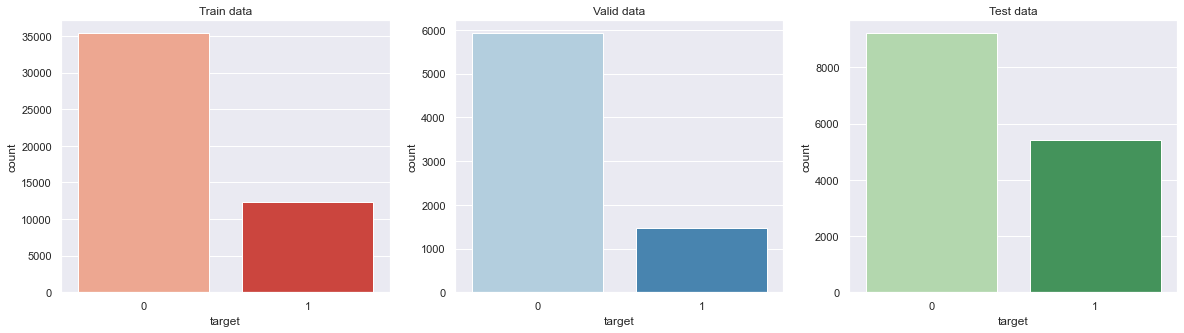

In [19]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

## VGG16

### Creating a custom model

Function for creating a VGG block.

In [20]:
def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [21]:
# define model input
visible = Input(shape=(224, 224, 3))

# add vgg module
layer = vgg_block(visible, 64, 2)
layer = vgg_block(layer, 128, 2)
layer = vgg_block(layer, 256, 3)
layer = vgg_block(layer, 512, 3)
layer = vgg_block(layer, 512, 3)

# add flatten
layer = keras.layers.Flatten()(layer)

# add Dense
layer = keras.layers.Dense(4096, activation='relu')(layer)
layer = keras.layers.Dense(4096, activation='relu')(layer)
layer = keras.layers.Dense(2, activation='sigmoid')(layer)

# create model
vgg_model = Model(inputs=visible, outputs=layer)
print(type(vgg_model))

# summarize model
vgg_model.summary()

<class 'keras.engine.functional.Functional'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                

### Training